# *Лабораторная работа №3*

## Определение типа дорожного знака (Теоретическая часть)

Подключим все необходимые библиотеки.

In [1]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим датасет в среду выполнения.

In [2]:
%%capture
!wget https://www.dropbox.com/s/7xi7of75tbuouo2/Meta.zip

Распакуем все данные для дальнейшей работы.

In [3]:
zip = ZipFile('Meta.zip')
zip.extractall()

Укажем основные пути к папкам и введем масштаб, к которому будем приводить все изображения датасета.

In [4]:
data_dir = '/content/'
train_path = '/content/Train'

height = 30
width = 30
channels = 3

Создадим массивы для хранения изображений и их категорий. Дополнительно рассмотрим общее количество категорий в данном датасете.

In [5]:
data = []
labels = []
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

Заполним массивы изображений и меток классов.

In [6]:
for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path,str(i))
    images = os.listdir(path)
    for a in images:
            image = Image.open(path + '/' + a)
            image = image.resize((height,width))
            image = np.array(image)
            data.append(image)
            labels.append(i)

data = np.array(data)
labels = np.array(labels)

Разобьем данные на тренировочную и тестовую выборки в рамках обучения нейронной сети. Также проведем нормализацию в процессе.

In [7]:
print(data.shape,labels.shape)

X_train, X_test, Y_train, Y_test = train_test_split(data,labels,test_size=0.2,random_state=42, shuffle=True)

X_train = X_train/255
X_test = X_test/255

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [8]:
Y_train=keras.utils.to_categorical(Y_train,NUM_CATEGORIES)
Y_test= keras.utils.to_categorical(Y_test,NUM_CATEGORIES)

print(Y_train.shape)
print(Y_test.shape)

(31367, 43)
(7842, 43)


Создадим модель, состоящую из последовательно идущих слоев:

*   Свертка (32 фильтра 3х3)
*   Свертка (32 фильтра 3х3)
*   Субдискретизация (фильтр max 2х2)
*   Свертка (64 фильтра 3х3)
*   Свертка (64 фильтра 3х3)
*   Субдискретизация (фильтр max 2х2)
*   Полносвязный слой (512 нейронов)
*   Полносвязный слой (*количество_категорий* нейронов)

Кроме того введем выключение части нейронов для предотвращения переобучения.


In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(height,width,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 9, 9, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 612,427 (2.34 MB)

 Trainable params: 612,427 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Скомпилируем созданную модель.

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Зададим функцию аугментации, чтобы незначительно изменять изображения для искусственного расширения набора данных при обучении.

In [11]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

Задаим размер пакета обучения равным 32 и количсество эпох равным 15.

In [12]:
batch_size = 32
epochs = 15

history = model.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, Y_test) )

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 136s 133ms/step - accuracy: 0.2330 - loss: 2.7763 - val_accuracy: 0.9069 - val_loss: 0.3153
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 125s 127ms/step - accuracy: 0.7831 - loss: 0.6807 - val_accuracy: 0.9693 - val_loss: 0.0982
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 147s 132ms/step - accuracy: 0.8907 - loss: 0.3531 - val_accuracy: 0.9871 - val_loss: 0.0414
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 128s 131ms/step - accuracy: 0.9257 - loss: 0.2394 - val_accuracy: 0.9920 - val_loss: 0.0287
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 128s 131ms/step - accuracy: 0.9394 - loss: 0.1949 - val_accuracy: 0.9949 - val_loss: 0.0190
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 130s 133ms/step - accuracy: 0.9513 - loss: 0.1636 - val_accuracy: 0.9946 - val_loss: 0.0215
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 127s 129ms/step - accuracy: 0.9549 - loss: 0.1412 - val_accuracy: 0.9953 - val_loss: 0.0152
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 127s 130ms/step - accuracy: 0.9618 - loss: 0.11

Выведем графики изменения точности и величины функции ошибки в процессе обучения модели.

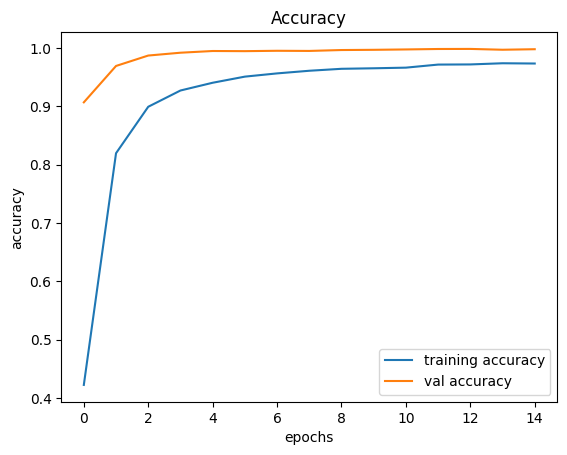

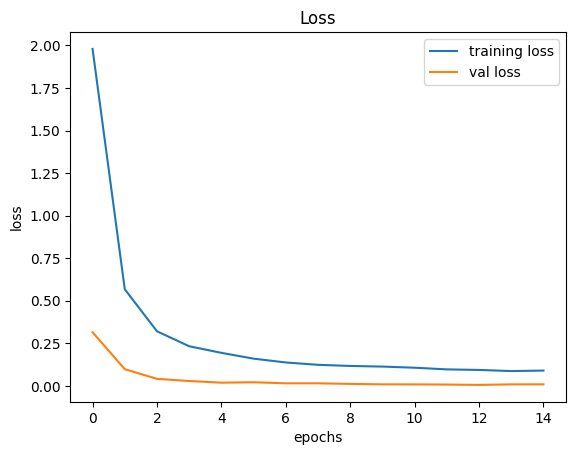

In [13]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Повторим все действия, которые мы делали для подготовки тренировочного набора данных, для тестовых данных.

In [14]:
test = pd.read_csv(data_dir + 'Test.csv')

labels = test["ClassId"].values
images = test["Path"].values

data=[]

for a in images:
  image = Image.open(data_dir + '/' + a)
  image = image.resize((height,width))
  image = np.array(image)
  data.append(image)

In [15]:
X_pred = np.array(data)
X_pred = X_pred/255

Получим предсказание величин для тестовой выборки.

In [17]:
pred_x = model.predict(X_pred)
pred = np.argmax(pred_x, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step


Выведем величину метрики точности для тестового набора данных.

In [18]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  97.41092636579573


## Определение вида бабочки по изображению (Практическая часть)

В наборе данных представлены фотографии 75 видов бабочек. Все изображения имеют разрешение 224х224. Имя каждого файла состоит из названия вида бабочки и порядкового номера изображения.

Ниже приведен блок кода для загрузки тренировочной (разделение ее на обучающую и тестовую части остается на усмотрение исполнителя) и валидационной выборки. Валидационная часть не участвует в обучении, только в получении итоговой оценки.

In [1]:
%%capture
!wget -O train.zip https://www.dropbox.com/scl/fi/bel6gt6vsb3onahlxvyjc/train_fix.zip?rlkey=q2wscp6wv9j2hbk07y1mbcm54&dl=0
!wget -O valid.zip https://www.dropbox.com/scl/fi/cwwblwhvqgwubb8a4xg90/valid.zip?rlkey=mow899lvyawq4wku2m8lfvrh3&dl=0

Архитектура нейронной сети должна быть составлена самостоятельно и не содержать предобученных весов.

Оценка полученного решения складывается из двух факторов:

1. Значение метрики Accuracy_score.
2. Общее время, которое потребовалось модели для предсказания всех меток из валидационного датасета.